In [1]:
import sys
from pathlib import Path
from datetime import timedelta
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
import os
import random
import torch.nn as nn
from scipy import signal
import seaborn as sns


In [2]:
def seed_everything(seed = 777):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [3]:
df = pd.read_pickle('/dshome/ddualab/gyu/kamp/data/plastic_deformation.pkl')
df.head()

,date,EX5.MELT_TEMP,EX4.MELT_TEMP,EX3.MELT_TEMP,EX2.MELT_TEMP,EX1.Z1_PV,EX1.Z2_PV,EX1.Z3_PV,EX1.Z4_PV,EX1.A1_PV,EX1.A2_PV,EX1.H1_PV,EX1.H2_PV,EX1.H3_PV,EX1.H4_PV,EX1.H2O_PV,EX1.MELT_P_PV,EX1.MD_PV,EX1.MD_TQ,passorfail
0,2020 10 30 00:00:04,297,222,251,267,209,219,229,239,240,239,241,240,240,40,41,0.0,71.2215,72,0.0
1,2020 10 30 00:00:09,297,222,251,268,210,219,229,239,240,239,240,240,240,40,41,0.0,71.2096,72,0.0
2,2020 10 30 00:00:14,297,222,251,267,210,219,229,239,240,239,240,240,240,40,41,0.0,71.1977,72,0.0
3,2020 10 30 00:00:19,297,222,251,267,210,219,229,240,240,239,241,240,240,40,41,0.0,71.1977,72,0.0
4,2020 10 30 00:00:24,297,222,251,267,210,219,229,239,240,239,241,240,240,40,41,0.0,71.1977,72,0.0


## 1. EDA


🎯 Target(`passorfail`) 분포:
passorfail
0.0    0.993628
1.0    0.006372
Name: proportion, dtype: float64


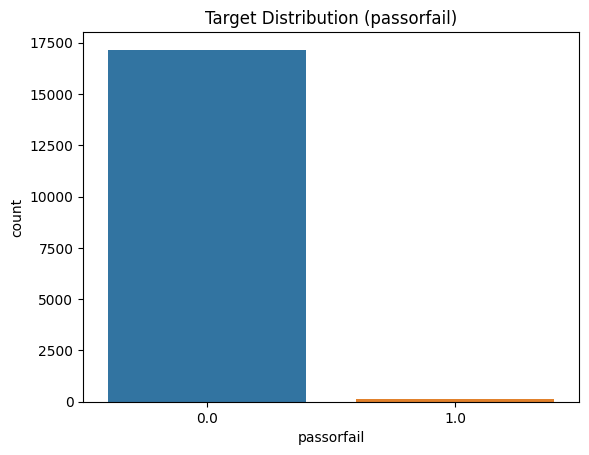

In [4]:
# === 5. 타겟 분포 확인 ===
print("\n🎯 Target(`passorfail`) 분포:")
print(df['passorfail'].value_counts(normalize=True))
sns.countplot(x='passorfail', data=df)
plt.title("Target Distribution (passorfail)")
plt.show()


## 2. Utill



In [68]:
def train_valid_test_split(df, time_col='date', label_col='passorfail', ratios=(0.6, 0.2, 0.2)):

    df['date'] = pd.to_datetime(df['date'], format='%Y %m %d %H:%M:%S')
    
    # 1️⃣ 시간 순으로 정렬
    df = df.sort_values(time_col).reset_index(drop=True)
    
    # 2️⃣ 비율 계산
    n = len(df)
    n_train = int(n * ratios[0])
    n_valid = int(n * ratios[1])
    
    # 3️⃣ 구간 나누기
    train_df = df.iloc[:n_train]
    valid_df = df.iloc[n_train:n_train + n_valid]
    test_df  = df.iloc[n_train + n_valid:]
    
    # 4️⃣ 구간 정보 출력
    print("✅ train_valid_test_split complete:")
    print(f"Train: {train_df.shape[0]} rows ({ratios[0]*100:.0f}%)")
    print(f"Valid: {valid_df.shape[0]} rows ({ratios[1]*100:.0f}%)")
    print(f"Test : {test_df.shape[0]} rows ({ratios[2]*100:.0f}%)")
    print(f"\n📅 Time range:")
    print(f"  Train: {train_df[time_col].iloc[0]} → {train_df[time_col].iloc[-1]}")
    print(f"  Valid: {valid_df[time_col].iloc[0]} → {valid_df[time_col].iloc[-1]}")
    print(f"  Test : {test_df[time_col].iloc[0]} → {test_df[time_col].iloc[-1]}")
    
    return {
        "train": train_df,
        "valid": valid_df,
        "test": test_df
    }


splits = train_valid_test_split(df, time_col='date', label_col='passorfail', ratios=(0.6, 0.2, 0.2))

train_df = splits['train']
valid_df = splits['valid']
test_df  = splits['test']

✅ train_valid_test_split complete:
Train: 10358 rows (60%)
Valid: 3452 rows (20%)
Test : 3454 rows (20%)

📅 Time range:
  Train: 2020-10-30 00:00:04 → 2020-10-30 14:23:09
  Valid: 2020-10-30 14:23:14 → 2020-10-30 19:10:49
  Test : 2020-10-30 19:10:54 → 2020-10-30 23:58:39


In [69]:
train_df.shape, valid_df.shape, test_df.shape

((10358, 20), (3452, 20), (3454, 20))

In [70]:
def get_tag_minmax(df, exclude_cols=None):
    """
    df : 전체 DataFrame
    exclude_cols : 날짜나 타겟 컬럼 등, 통계 계산에서 제외할 컬럼
    """
    if exclude_cols is None:
        exclude_cols = []
    valid_cols = [c for c in df.columns if c not in exclude_cols]
    tag_min = df[valid_cols].min()
    tag_max = df[valid_cols].max()
    return tag_min, tag_max, valid_cols


# min-max 정규화 함수
def normalize(df, tag_min, tag_max):
    ndf = df.copy()
    for c in df.columns:
        if c in tag_min.index:
            if tag_min[c] == tag_max[c]:
                ndf[c] = df[c] - tag_min[c]
            else:
                ndf[c] = (df[c] - tag_min[c]) / (tag_max[c] - tag_min[c])
    return ndf


# ③ 지수이동평균(EMA) 적용 함수
def apply_ema(df, alpha=0.9):
    """
    alpha : 최근 값의 가중치 (0.9면 최근 시점에 90% 가중치)
    """
    return df.ewm(alpha=alpha).mean()


# ④ Boundary Check 함수
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return {
        "above_1": np.any(x > 1.0),
        "below_0": np.any(x < 0.0),
        "has_nan": np.any(np.isnan(x))
    }


In [71]:
# === Train ===
tag_min_train, tag_max_train, train_cols = get_tag_minmax(train_df, exclude_cols=['date', 'passorfail'])
train_norm = normalize(train_df[train_cols], tag_min_train, tag_max_train)
train_ema = apply_ema(train_norm, alpha=0.9)
print("Train Check:", boundary_check(train_ema))
train_processed = pd.concat([train_df[['date', 'passorfail']], train_ema], axis=1)

# === Valid ===
tag_min_valid, tag_max_valid, valid_cols = get_tag_minmax(valid_df, exclude_cols=['date', 'passorfail'])
valid_norm = normalize(valid_df[valid_cols], tag_min_valid, tag_max_valid)
valid_ema = apply_ema(valid_norm, alpha=0.9)
print("Valid Check:", boundary_check(valid_ema))
valid_processed = pd.concat([valid_df[['date', 'passorfail']], valid_ema], axis=1)

# === Test ===
tag_min_test, tag_max_test, test_cols = get_tag_minmax(test_df, exclude_cols=['date', 'passorfail'])
test_norm = normalize(test_df[test_cols], tag_min_test, tag_max_test)
test_ema = apply_ema(test_norm, alpha=0.9)
print("Test Check :", boundary_check(test_ema))
test_processed = pd.concat([test_df[['date', 'passorfail']], test_ema], axis=1)

Train Check: {'above_1': False, 'below_0': False, 'has_nan': False}
Valid Check: {'above_1': False, 'below_0': False, 'has_nan': False}
Test Check : {'above_1': False, 'below_0': False, 'has_nan': False}


In [72]:
# import torch
# from torch.utils.data import Dataset
# import numpy as np
# from datetime import timedelta
# from tqdm import trange
# import pandas as pd
# import dateutil

# class PlasticProcessDataset(Dataset):
#     """
#     📦 시계열 이상탐지용 슬라이딩 윈도우 데이터셋 (소성가공 공정용)
    
#     Parameters
#     ----------
#     timestamps : pd.Series or np.ndarray
#         시계열 datetime 값 (예: df['date'])
#     df : pd.DataFrame
#         정규화된 feature 데이터 (date, passorfail 제외)
#     window_given : int, default=39
#         입력으로 주어질 시점의 개수
#     window_size : int, default=40
#         window 전체 길이 (given + 1)
#     stride : int, default=1
#         슬라이딩 윈도우 간격 (1이면 모든 시점)
#     labels : array-like, optional
#         라벨 (예: df['passorfail']), 없으면 None
#     """

#     def __init__(self, timestamps, df, window_given=39, window_size=40, stride=1, labels=None):
#         self.ts = np.array(timestamps)
#         self.values = np.array(df, dtype=np.float32)
#         self.window_given = window_given
#         self.window_size = window_size
#         self.labels = np.array(labels, dtype=np.float32) if labels is not None else None
        
#         # 연속된 시계열 window 인덱스 생성
#         self.valid_idxs = []
#         for L in trange(len(self.ts) - self.window_size + 1, desc="Generating windows"):
#             R = L + self.window_size - 1
#             # 시계열이 연속(1초 간격)인지 확인
#             if dateutil.parser.parse(str(self.ts[R])) - dateutil.parser.parse(str(self.ts[L])) == timedelta(seconds=(self.window_size - 1) * 5):
#                 self.valid_idxs.append(L)
#         self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
#         self.n_idxs = len(self.valid_idxs)
#         print(f"✅ {self.n_idxs} windows created.")

#     def __len__(self):
#         return self.n_idxs

#     def __getitem__(self, idx):
#         i = self.valid_idxs[idx]
#         last = i + self.window_size - 1
#         sample = {
#             "ts": self.ts[last],  # window의 마지막 시점
#             "given": torch.from_numpy(self.values[i : i + self.window_given]),  # 입력 시퀀스
#             "answer": torch.from_numpy(self.values[last])  # 다음 시점(target)
#         }
#         # 라벨이 있으면 추가
#         if self.labels is not None:
#             sample["label"] = self.labels[last]
#         return sample


In [80]:
import torch
from torch.utils.data import Dataset
import numpy as np
from tqdm import trange
import pandas as pd

class PlasticProcessDataset(Dataset):
    """
    📦 시계열 이상탐지용 슬라이딩 윈도우 데이터셋 (소성가공 공정용)
    - 정상 데이터를 기반으로 reconstruction 학습
    - window_given: 입력 구간 길이
    - window_size: 전체 윈도우 길이 (예측 포함)
    """

    def __init__(self, timestamps, df, window_given=39, window_size=40, stride=1,
                 labels=None, step_seconds=5, allow_incomplete=False):
        self.timestamps = pd.to_datetime(timestamps).reset_index(drop=True)
        self.values = np.array(df, dtype=np.float32)
        self.window_given = window_given
        self.window_size = window_size
        self.labels = np.array(labels, dtype=np.float32) if labels is not None else None
        self.step_seconds = step_seconds
        self.allow_incomplete = allow_incomplete

        total = len(self.timestamps)
        limit = total - self.window_size + 1 if not allow_incomplete else total

        self.valid_idxs = []
        for L in trange(limit, desc="Generating windows"):
            R = min(L + self.window_size - 1, total - 1)
            diffs = np.diff(self.timestamps[L:R + 1]).astype("timedelta64[s]").astype(int)
            if np.all(diffs == self.step_seconds):
                self.valid_idxs.append(L)

        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"✅ {self.n_idxs} windows created.")

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        L = self.valid_idxs[idx]
        R = L + self.window_size

        given = self.values[L:L + self.window_given]       # 입력 시퀀스
        answer = self.values[L + 1:R]                      # 다음 시퀀스
        label = self.labels[L + self.window_size - 1] if self.labels is not None else -1
        timestamp = self.timestamps[L + self.window_size - 1]

        return {
            "given": torch.tensor(given, dtype=torch.float32),
            "answer": torch.tensor(answer, dtype=torch.float32),
            "label": torch.tensor(label, dtype=torch.float32),
            # "timestamp": timestamp
        }


In [81]:
# Train set
features_train = train_processed.drop(columns=['date', 'passorfail'])
timestamps_train = train_processed['date']
labels_train = train_processed['passorfail']

# Validation set
features_valid = valid_processed.drop(columns=['date', 'passorfail'])
timestamps_valid = valid_processed['date']
labels_valid = valid_processed['passorfail']

# Test set
features_test = test_processed.drop(columns=['date', 'passorfail'])
timestamps_test = test_processed['date']
labels_test = test_processed['passorfail']


In [82]:
timestamps_train

0       2020-10-30 00:00:04
1       2020-10-30 00:00:09
2       2020-10-30 00:00:14
3       2020-10-30 00:00:19
4       2020-10-30 00:00:24
                ...        
10353   2020-10-30 14:22:49
10354   2020-10-30 14:22:54
10355   2020-10-30 14:22:59
10356   2020-10-30 14:23:04
10357   2020-10-30 14:23:09
Name: date, Length: 10358, dtype: datetime64[ns]

In [83]:
# ✅ Train dataset
train_dataset = PlasticProcessDataset(
    timestamps=timestamps_train,
    df=features_train,
    labels=labels_train,
    window_given=39,
    window_size=40,
    stride=1
)

# ✅ Validation dataset
valid_dataset = PlasticProcessDataset(
    timestamps=timestamps_valid,
    df=features_valid,
    labels=labels_valid,
    window_given=39,
    window_size=40,
    stride=1
)

# ✅ Test dataset
test_dataset = PlasticProcessDataset(
    timestamps=timestamps_test,
    df=features_test,
    labels=labels_test,
    window_given=39,
    window_size=40,
    stride=1
)


Generating windows:   0%|          | 0/10319 [00:00<?, ?it/s]

Generating windows: 100%|██████████| 10319/10319 [00:00<00:00, 11099.31it/s]


✅ 10319 windows created.


Generating windows: 100%|██████████| 3413/3413 [00:00<00:00, 11204.74it/s]


✅ 3413 windows created.


Generating windows: 100%|██████████| 3415/3415 [00:00<00:00, 11169.90it/s]

✅ 3415 windows created.


## 03. Model

In [84]:
import torch
import torch.nn as nn

N_FEATURES = 18   # 입력 변수 개수 (date, passorfail 제외)
N_HIDDENS = 200
N_LAYERS = 3
BATCH_SIZE = 512
EPOCHS = 50

class StackedLSTM(nn.Module):
    def __init__(self, input_dim=N_FEATURES, hidden_dim=N_HIDDENS, num_layers=N_LAYERS, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # === 1. LSTM Encoder ===
        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout
        )

        # === 2. FC Decoder ===
        self.fc = nn.Linear(hidden_dim * 2, input_dim)
        self.relu = nn.LeakyReLU(0.1)

        # === 3. Feature Attention Layers ===
        self.dense1 = nn.Linear(input_dim, input_dim // 2)
        self.dense2 = nn.Linear(input_dim // 2, input_dim)
        self.sigmoid = nn.Sigmoid()

        # === 4. Learnable mix factor (skip connection) ===
        self.w = nn.Parameter(torch.FloatTensor([-0.01]), requires_grad=True)

    def forward(self, x):
        # x: (batch, window_size, n_features)
        B, T, F = x.size()

        # === Feature Attention ===
        pool = nn.AdaptiveAvgPool1d(1)
        attention_x = x.transpose(1, 2)         # (B, F, T)
        attention = pool(attention_x)           # (B, F, 1)
        connection = attention.view(B, F)       # (B, F)

        # Dense layers → attention weights (0~1)
        attention = self.relu(attention.squeeze(-1))
        attention = self.relu(self.dense1(attention))
        attention = self.sigmoid(self.dense2(attention))  # (B, F)

        # === LSTM Encoder ===
        x = x.transpose(0, 1)                   # (T, B, F)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(self.relu(outs[-1]))      # (B, F)

        # === Mix-up Skip Connection ===
        mix_factor = self.sigmoid(self.w)
        output = mix_factor * connection * attention + out * (1 - mix_factor)
        return output


## 04. Train

In [89]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
import sys

def train(dataset, model, batch_size, n_epochs, device):
    """
    단일 데이터셋(train)으로 모델을 학습하는 함수.
    - dataset: 학습 데이터셋
    - model: PyTorch 모델
    - device: 'cuda' or 'cpu'
    - 반환: best 모델 상태(best)와 손실 기록(history)
    """

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = torch.nn.MSELoss()

    epochs = trange(n_epochs, desc="training", leave=True)
    best = {"loss": sys.float_info.max}
    history = {"train": []}  # ✅ train만 기록

    model.train()

    for e in epochs:
        epoch_loss = 0.0

        for batch in dataloader:
            optimizer.zero_grad()

            # 입력, 정답 GPU로 이동
            given = batch["given"].to(device)     # (B, T, F)
            answer = batch["answer"].to(device)   # (B, T, F) or (B, F)

            # 모델 예측
            guess = model(given)                  # (B, F)

            # Reconstruction Loss 계산
            if answer.ndim == 3:
                target = answer[:, -1, :]         # 시퀀스면 마지막 시점만
            else:
                target = answer

            loss = loss_fn(guess, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        history["train"].append(avg_loss)
        epochs.set_postfix_str(f"loss: {avg_loss:.6f}")

        # Best model 저장
        if avg_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = avg_loss
            best["epoch"] = e + 1

    print(f"✅ Best loss: {best['loss']:.6f} at epoch {best['epoch']}")
    return best, history


In [90]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

MODEL = StackedLSTM(input_dim=18).to(device)

best, loss_history = train(
    dataset=train_dataset,  # 정상 데이터만 포함
    model=MODEL,
    batch_size=512,
    n_epochs=100,
    device=device
)


training:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Best loss: 0.004869 at epoch 88


In [92]:
# ✅ Best 결과 확인
print("Best loss:", best["loss"])
print("Best epoch:", best["epoch"])

Best loss: 0.004868844302282447
Best epoch: 88


In [93]:
# ✅ 모델 저장
torch.save(
    {
        "state_dict": best["state"],
        "best_epoch": best["epoch"],
        "train_loss_history": loss_history["train"],
    },
    "./model_best.pt"
)

print("✅ Model saved to ./model_best.pt")


✅ Model saved to ./model_best.pt


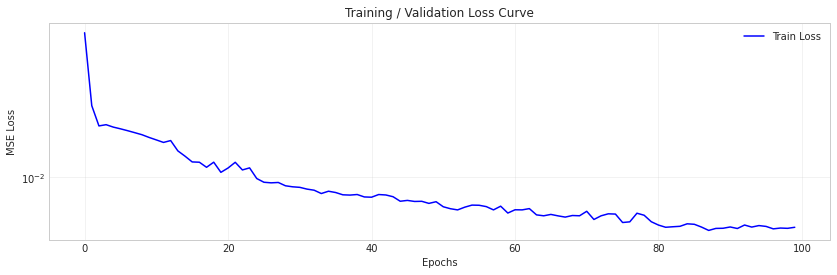

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.title("Training / Validation Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.yscale("log")

plt.plot(loss_history["train"], label="Train Loss", color="blue")

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 05. inference


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def eval(dataset, model, batch_size=512, device="cuda"):
    """
    ✅ Reconstruction 기반 이상탐지 평가 함수 (validation, test 공용)
    - dataset: {"given": (B,T,F), "answer": (B,T,F or B,F), (optional) "label": (B,)}
    - 반환: (errors: np.ndarray [N,], labels: np.ndarray [N,] or None)
    """
    device = torch.device(device)
    model.to(device)
    model.eval()

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_errors, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            given  = batch["given"].to(device)       # (B,T,F)
            answer = batch["answer"].to(device)      # (B,T,F) or (B,F)

            # 모델 예측
            guess = model(given)                     # (B,F)

            # 타겟(마지막 시점 또는 그대로)
            target = answer[:, -1, :] if answer.ndim == 3 else answer  # (B,F)

            # per-sample MSE over features → (B,)
            errors = torch.mean((guess - target) ** 2, dim=1).cpu().numpy()
            all_errors.append(errors)

            # 라벨이 있으면 모으기(없으면 건너뜀)
            lab = batch.get("label", None)
            if lab is not None:
                all_labels.append(lab.cpu().numpy())

    errors = np.concatenate(all_errors) if all_errors else np.array([])
    labels = np.concatenate(all_labels) if all_labels else None

    print(f"✅ Inference complete: {len(errors)} samples")
    return errors, labels


In [106]:
import numpy as np
from sklearn.metrics import roc_auc_score

def _safe_div(a, b):
    return (a / b) if b else 0.0

def print_metrics(errors, labels, threshold, name="DATASET", try_auc=True):
    labels = np.asarray(labels).astype(int)
    preds  = (np.asarray(errors) > float(threshold)).astype(int)

    # Confusion matrix terms
    tp = int(((preds == 1) & (labels == 1)).sum())
    fp = int(((preds == 1) & (labels == 0)).sum())
    tn = int(((preds == 0) & (labels == 0)).sum())
    fn = int(((preds == 0) & (labels == 1)).sum())

    # Precision / Recall / F1 (수식으로 안전 계산)
    P  = _safe_div(tp, tp + fp)
    R  = _safe_div(tp, tp + fn)
    F1 = _safe_div(2 * P * R, P + R) if (P + R) > 0 else 0.0

    print(f"\n=== {name} Metrics ===")
    # AUC는 양/음성 모두 있을 때만
    if try_auc and np.unique(labels).size == 2:
        print(f"AUC : {roc_auc_score(labels, errors):.6f}")
    else:
        print("AUC : N/A (only one class in labels)")

    print(f"P   : {P:.6f}")
    print(f"R   : {R:.6f}")
    print(f"F1  : {F1:.6f}")
    print(f"[TP:{tp} FP:{fp} TN:{tn} FN:{fn} | Pos:{labels.sum()} Neg:{(labels==0).sum()}]")


In [107]:
# Validation
val_errors, val_labels = eval(valid_dataset, MODEL, batch_size=512, device=device)
VAL_THRESHOLD = float(np.percentile(val_errors, 95))
print("VAL_THRESHOLD =", VAL_THRESHOLD)
print_metrics(val_errors, val_labels, VAL_THRESHOLD, name="Validation")

✅ Inference complete: 3413 samples
VAL_THRESHOLD = 0.08982525318861005

=== Validation Metrics ===
AUC : N/A (only one class in labels)
P   : 0.000000
R   : 0.000000
F1  : 0.000000
[TP:0 FP:171 TN:3242 FN:0 | Pos:0 Neg:3413]


In [108]:
# Test (같은 임계값 사용)
test_errors, test_labels = eval(test_dataset, MODEL, batch_size=512, device=device)
print_metrics(test_errors, test_labels, VAL_THRESHOLD, name="Test")

✅ Inference complete: 3415 samples

=== Test Metrics ===
AUC : N/A (only one class in labels)
P   : 0.000000
R   : 0.000000
F1  : 0.000000
[TP:0 FP:133 TN:3282 FN:0 | Pos:0 Neg:3415]


In [ ]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [101]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()